### Partie C- Classification : diabetes

### 1.1 Chargement des données
 le fichier `diabetes.csv`

In [80]:
# Étape 1 : Chargement des données
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Nettoyage et prétraitement
### 2.1.  Gestion des zéros/missing dans les variables cliniques


In [81]:
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)
print("Valeurs manquantes :")
print(df.isnull().sum())

# Remplissage par la médiane
df[cols_to_clean] = df[cols_to_clean].fillna(df[cols_to_clean].median())


Valeurs manquantes :
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### 2.2. Standardisation des mesures

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Outcome', axis=1))
y = df['Outcome']


### 3. EDA & déséquilibe

### 3.1  Barplots du nombre de positifs/négatifs

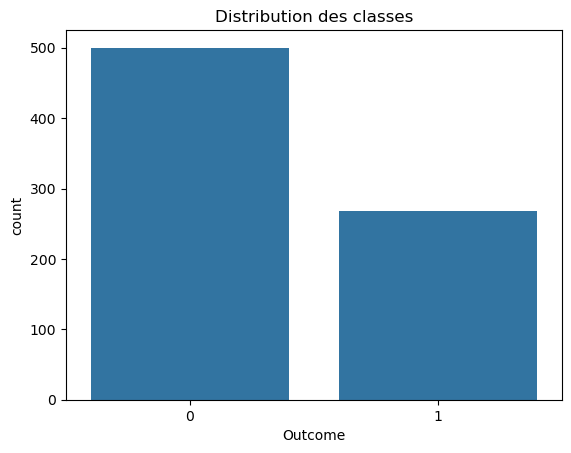

In [83]:
sns.countplot(x='Outcome', data=df)
plt.title("Distribution des classes")
plt.show()

### 3.2 statistiques descriptives par classe. 

In [84]:
df.groupby('Outcome').describe()

Pregnancies                                                Glucose  \
              count      mean       std  min   25%  50%  75%   max   count   
Outcome                                                                      
0             500.0  3.298000  3.017185  0.0  1.00  2.0  5.0  13.0   500.0   
1             268.0  4.865672  3.741239  0.0  1.75  4.0  8.0  17.0   268.0   

                     ... DiabetesPedigreeFunction           Age             \
               mean  ...                      75%    max  count       mean   
Outcome              ...                                                     
0        110.682000  ...                  0.56175  2.329  500.0  31.190000   
1        142.130597  ...                  0.72800  2.420  268.0  37.067164   

                                                  
               std   min   25%   50%   75%   max  
Outcome                                           
0        11.667655  21.0  23.0  27.0  37.0  81.0  
1        10.968254  21.0  28.0  36.0  44.0  70.0  

[2 rows x 64 columns]

### 4. Split Train/ Validation/ Test

In [85]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


### 5.  Feature Engineering / Sélection

In [88]:
# Pas d'encodage nécessaire car tout est numérique
# Les données sont déjà standardisées

In [89]:
# Installation du imbalanced-learn 
!pip install imbalanced-learn

### 6. Gestion du déséquilibre  

Avant SMOTE: Outcome
0    300
1    160
Name: count, dtype: int64
Après SMOTE: Outcome
0    300
1    300
Name: count, dtype: int64


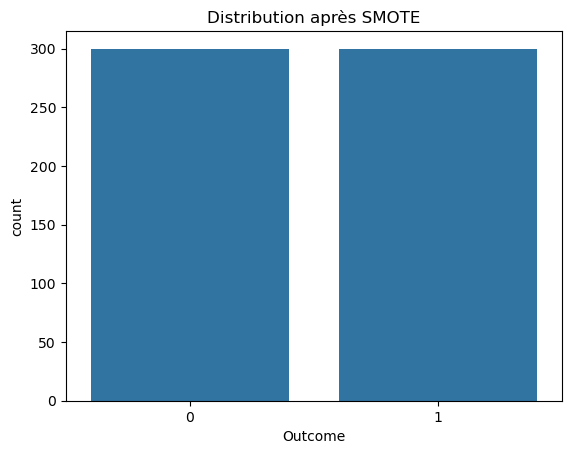

In [90]:
from imblearn.over_sampling import SMOTE

print("Avant SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Après SMOTE:", y_train_bal.value_counts())

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train_bal)
plt.title("Distribution après SMOTE")
plt.show()


### 7. Modélisation initiale : Logistic Regression. Evaluation Accuracy, Precision, Recall, F1 sur validation

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)

y_val_pred = model.predict(X_val)

print("Évaluation sur le set de validation :")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))


Évaluation sur le set de validation :
Accuracy: 0.7532467532467533
Precision: 0.6428571428571429
Recall: 0.6666666666666666
F1 Score: 0.6545454545454545


### 8. Évaluation finale : Matrice de confusion, analyses sur le test set

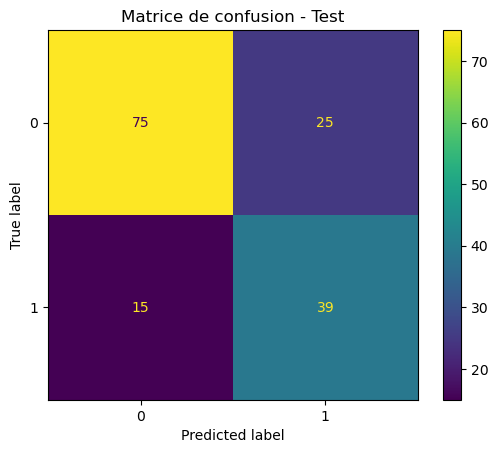

F1 Score (Test): 0.6610169491525424


In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matrice de confusion - Test")
plt.show()

print("F1 Score (Test):", f1_score(y_test, y_test_pred))


### 9. Explainability : Importance des features, analyse des erreurs (faux positifs/faux négatifs, f1-score)

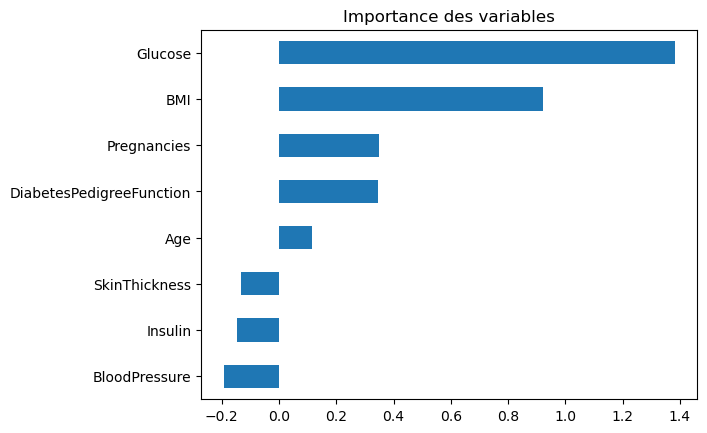

Faux positifs : 25
Faux négatifs : 15


In [93]:
importances = model.coef_[0]
features = df.columns[:-1]
feature_importance = pd.Series(importances, index=features).sort_values()

feature_importance.plot(kind='barh')
plt.title("Importance des variables")
plt.show()

errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print("Faux positifs :", len(errors[(errors['Actual']==0) & (errors['Predicted']==1)]))
print("Faux négatifs :", len(errors[(errors['Actual']==1) & (errors['Predicted']==0)]))


## 10. Conclusions
- Le modèle de régression logistique donne une performance initiale solide avec SMOTE.
- Le traitement des valeurs nulles par la médiane a permis de stabiliser les features.
- Pour améliorer la performance, explorer des modèles comme Random Forest ou XGBoost.
- Vérifier l’origine des erreurs et améliorer la qualité des données collectées.
